# Scaling TTI equations from Fletcher et al

In [36]:
# import dependencies
import devito as dv
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from examples.seismic.source import TimeAxis
from examples.seismic import RickerSource
from scipy.ndimage import gaussian_filter

## Transforming equations from 3d to 2d

Fletcher et al. 2009 defines a coupled PDE system from a P-SV TTI dispersion relation as:

$\frac{\partial^2 p}{\partial t^2} = v_{px}^2 H_2 p + \alpha v_{pz}^2 H_1 q + v_{sz}^2 H_1 (p - \alpha q)$

$\frac{\partial^2 q}{\partial t^2} = \frac{v_{pn}^2}{\alpha} H_2 p + v_{pz}^2 H_1 q - v_{sz}^2 H_2 \left( \frac{1}{\alpha} p - q \right)$

Where $v_{pz}$ is the P-wave velocity in the direction normal to the symmetry plane, $v_{pn} = v_{pz}\sqrt{1 + 2\delta}$ with $v_{pn}$ being the P-wave NMO velocity, $v_{px} = v_{pz}\sqrt{1 + 2\epsilon}$ with $v_{px}$ being the P-wave velocity in the symmetry plane, $v_{sz}$ is the SV velocity normal to the symmetry plane, $\delta$ and $\epsilon$ are anisotropy parameters defined by Thomsen 1986 and $\alpha$ is a non-zero scalar used to parameterise the equations. $H_1$ and $H_2$ are derivative operators defined as:

$H_1 = \sin^2\theta \cos^2\phi \frac{\partial^2}{\partial x^2} + \sin^2\theta \sin^2\phi \frac{\partial^2}{\partial y^2} + \cos^2\theta \frac{\partial^2}{\partial z^2} + \sin^2\theta \sin 2\phi \frac{\partial^2}{\partial x \partial y} + \sin 2\theta \sin\phi \frac{\partial^2}{\partial y \partial z} + \sin 2\theta \cos\phi \frac{\partial^2}{\partial x \partial z} $

$H_2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2} - H_1$

The operators above are three dimensional, so to solve the equations in two dimensions we set $\frac{\partial}{\partial y}$ and $\phi$ equal to zero. This leads to two dimensional derivative operators defined as:

$H'_1 = \sin^2\theta \frac{\partial^2}{\partial x^2} + \cos^2\theta \frac{\partial^2}{\partial z^2} + \sin 2\theta \frac{\partial^2}{\partial x \partial z} $

$H'_2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial z^2} - H'_1$

Using these two dimensional operators, we define a new set of coupled PDEs as:

$\frac{\partial^2 p}{\partial t^2} = v_{px}^2 H'_2 p + \alpha v_{pz}^2 H'_1 q + v_{sz}^2 H'_1 (p - \alpha q)$

$\frac{\partial^2 q}{\partial t^2} = \frac{v_{pn}^2}{\alpha} H'_2 p + v_{pz}^2 H'_1 q - v_{sz}^2 H'_2 \left( \frac{1}{\alpha} p - q \right)$

Below, we implement this 2d coupled system using a $v_{pz}$ of 3000m/s, a $v_{sz}$ of zero, $\epsilon$ of 0.24, $\delta$ of 0.1, $\theta$ of 45 degrees and an $\alpha$ of 1

In [37]:
# setting up a grid 
extent = (2000, 2000)
shape = (201, 201)
x = dv.SpaceDimension('x')
z = dv.SpaceDimension('z')
grid = dv.Grid(extent=extent, shape=shape, dimensions=(x, z))

# creating functions for the two pressure fields
p = dv.TimeFunction(name='p', grid=grid, space_order=8, time_order=2)
q = dv.TimeFunction(name='q', grid=grid, space_order=8, time_order=2)

# constants, delta, epsilon and alpha are dimensionless, theta is radians, f0 is kHz
constants = {
    "delta": 0.1,
    "epsilon": 0.24,
    "sigma": 0.75,
    "theta": sp.pi/4,  # Keep symbolic pi here for symbolic operations
    "alpha": 1,
    "f0": 0.03
}

# velocities in km/s
v = {
    "pz": 3,
    "px": 3 * dv.sqrt(1 + 2 * constants["epsilon"]),
    "pn": 3 * dv.sqrt(1 + 2 * constants["delta"]),
    "sz": dv.sqrt((3**2/constants["sigma"])*(constants["epsilon"]-constants["delta"]))
}

# define dt using the cfl condition, c=0.6
vmax = max(v["pz"], v["px"], v["pn"], v["sz"])
dt = np.amin(grid.spacing)*0.6/vmax

# define a time range for the source term
t0 = 0
tn = 250
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# creating source term, f=0.03 kHz (30Hz)
src = RickerSource(name='src', grid=grid, f0=constants["f0"], npoint=1, time_range=time_range)
# setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# defining derivative operator functions
def h1(function, theta):
    operator = dv.sin(theta)**2*function.dx2 + dv.cos(theta)**2*function.dz2 + dv.sin(2*theta)*function.dx.dz
    return operator

def h2(function, theta):
    operator = function.laplace - h1(function, theta)
    return operator

# defining equations
theta = constants["theta"]
alpha = constants["alpha"]

eq_p = p.dt2 - v["px"]**2 * h2(p, theta) - alpha * v["pz"]**2 * h1(q, theta) - v["sz"]**2 * (h1(p, theta) - alpha * h1(q, theta))
eq_q = q.dt2 - (v["pn"]**2 / alpha) * h2(p, theta) - v["pz"]**2 * h1(q, theta) + v["sz"]**2 * ((1 / alpha) * h2(p, theta) - h2(q, theta))

# defining stencils
stencil_p = dv.Eq(p.forward, dv.solve(eq_p, p.forward))
stencil_q = dv.Eq(q.forward, dv.solve(eq_q, q.forward))

# injecting the source term to the pressure field, edit expr to vary source term
src_p = src.inject(field=p.forward, expr=src)
src_q = src.inject(field=q.forward, expr=src)

# set up operator
op = dv.Operator([stencil_p, stencil_q] + src_p + src_q)
op(dt=dt)


Operator `Kernel` ran in 0.08 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.07856699999999986, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=2e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

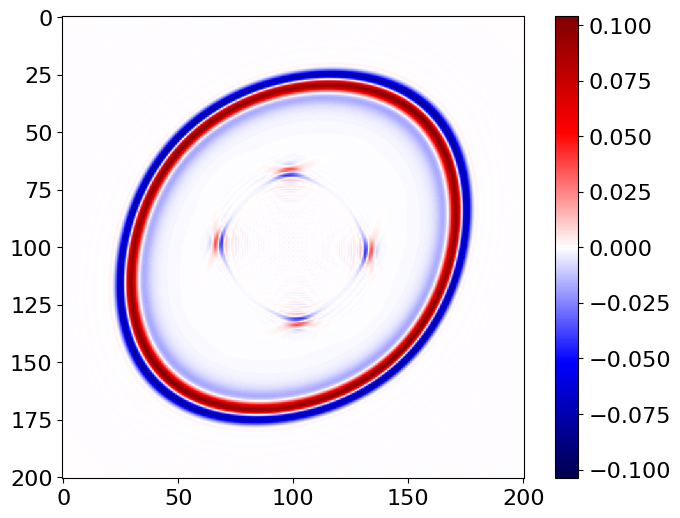

In [38]:
vmax = np.amax(np.abs(p.data[0]))
plt.imshow(p.data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

## Scaling for a constant parameter model

Here, we apply the same scaling technique as defined in [`unit-scaling-acoustic.ipynb`](./unit-scaling-acoustic.ipynb) to the coupled PDE system defined above. 

We first use the natural spatial unit of the problem (10m) to re-define our velocities from above (i.e. $v_{pz}$ = 3000m/s, $v_{px} = v_{pz}\sqrt{1+2\epsilon}$ m/s etc). This leads us to new velocities of $v_{pz}$ = 300(10m)/s, $v_{px}$ = 300 $\sqrt{1+2\epsilon}$ (10m)/s and $v_{pn}$ = 300 $\sqrt{1+2\delta}$ (10m)/s. 

We then use our new value of $v_{max}$ (our scaled $v_{px}$ of 300 $\sqrt{1+2\epsilon}$ (10m)/s) to calculate the timestep $\Delta t$ using the CFL condition with $c$ = 1 and $\Delta x$ = 1 (10m), finding $\Delta t$ to be $\frac{1}{300\sqrt{1+2\epsilon}}$ s.

Using this $\Delta t$ of $\frac{1}{300\sqrt{1+2\epsilon}}$ s, we define a new time unit of $\frac{1}{300\sqrt{1+2\epsilon}}$ s, rather than the SI unit of seconds.

Applying this time unit to our all time-dependent parameters leads to a new set of velocities, timestep, frequency and length $t_n$ of the simulation.

Using the new time unit, our velocities become: $v_{pz}$ = $\frac{300}{300\sqrt{1+2\epsilon}}$ (10m)/($\frac{1}{300\sqrt{1+2\epsilon}}$ s), $v_{pn}$ = $\frac{300\sqrt{1+2\delta}}{300\sqrt{1+2\epsilon}}$ (10m)/($\frac{1}{300\sqrt{1+2\epsilon}}$ s), and $v_{px}$ = $\frac{300\sqrt{1+2\epsilon}}{300\sqrt{1+2\epsilon}}$ (10m)/($\frac{1}{300\sqrt{1+2\epsilon}}$ s) = 1 (10m)/($\frac{1}{300\sqrt{1+2\epsilon}}$ s).

Using this new maximum velocity of 1 (10m)/($\frac{1}{300\sqrt{1+2\epsilon}}$ s), we can re-define $\Delta t$ using the CFL condition. This leads to a $\Delta t$ of 1 ($\frac{1}{300\sqrt{1+2\epsilon}}$ s) when using a Courant number of 1. The timestep here will always be equal to the Courant number selected.

We must also redefine the source frequency using the new time unit, leading to $f$ = 0.082Hz / ($\frac{1}{300\sqrt{1+2\epsilon}}$ s), (or 30Hz/s).

The length of the simulation $t_n$ is also affected by the new time unit. When scaling the grid, we reduce the extent by a factor of 10 so must reduce the simulation time by the same factor, bringing it from 250s to 25s. From here, we apply the time unit, multiplying the inital 25 s by $300\sqrt{1+2\epsilon}$.

Note that $v_{sz}$ is left unchanged, as this is set to zero in the simulation. The anisotropy parameters $\delta$ and $\epsilon$ are dimensionless so do not factor in to the scaling process as there are no units to scale. $\alpha$ is a non-zero scalar set to 1 so we have left this, and $\theta$ is left as $\sin\theta$ and $\cos\theta$ will always be between -1 and 1.

In [39]:
# setting up a new grid 
scaled_extent = (200, 200)
scaled_grid = dv.Grid(extent=scaled_extent, shape=shape, dimensions=(x, z))

# creating functions for the two scaled pressure fields
p_s = dv.TimeFunction(name='p_s', grid=scaled_grid, space_order=8, time_order=2)
q_s = dv.TimeFunction(name='q_s', grid=scaled_grid, space_order=8, time_order=2)

# defining constants and calculating velocities, scaling so the maximum is 1

# constants, sigma, epsilon and alpha are dimensionless, theta is radians, f0 is Hz
constants = {
    "delta": 0.1,
    "epsilon": 0.24,
    "sigma": 0.75,
    "theta": sp.pi/4,  # Keep symbolic pi here for symbolic operations
    "alpha": 1,
    "f0": 0.082
}

# velocities in 10m/s
v = {
    "pz": 300,
    "px": 300 * dv.sqrt(1 + 2 * constants["epsilon"]),
    "pn": 300 * dv.sqrt(1 + 2 * constants["delta"]),
    "sz": dv.sqrt((300**2/constants["sigma"])*(constants["epsilon"]-constants["delta"]))
}
# pull maximum velocity to scale others 
vmax = max(v["pz"], v["px"], v["pn"], v["sz"])

# velocities in (10m)/(1/(vmax) s)
scaled_v = {
    "pz": v["pz"]/vmax,
    "px": v["px"]/vmax,
    "pn": v["pn"]/vmax,
    "sz": v["sz"]/vmax
}

# define new dt using the cfl condition
scaled_vmax = max(scaled_v["pz"], scaled_v["px"], scaled_v["pn"], scaled_v["sz"])
scaled_dt = np.amin(scaled_grid.spacing)*0.6/scaled_vmax

# define a new time range for the source term
t0 = 0
scaled_tn = 0.25*(vmax)
scaled_time_range = TimeAxis(start=t0, stop=scaled_tn, step=scaled_dt)

# creating source term, f=0.082 Hz 
scaled_src = RickerSource(name='src', grid=scaled_grid, f0=constants["f0"], npoint=1, time_range=scaled_time_range)
# setting source to the middle of the grid
scaled_src.coordinates.data[:] = [100., 100.]

# Defining equations using values from dictionaries
theta = constants["theta"]
alpha = constants["alpha"]

# Equations using scaled velocities from the 'scaled_v' dictionary
scaled_eq_p = p_s.dt2 - scaled_v["px"]**2 * h2(p_s, theta) - alpha * scaled_v["pz"]**2 * h1(q_s, theta) - scaled_v["sz"]**2 * (h1(p_s, theta) - alpha * h1(q_s, theta))
scaled_eq_q = q_s.dt2 - (scaled_v["pn"]**2 / alpha) * h2(p_s, theta) - scaled_v["pz"]**2 * h1(q_s, theta) + scaled_v["sz"]**2 * ((1 / alpha) * h2(p_s, theta) - h2(q_s, theta))

# injecting the source term to the pressure field, edit expr to vary source term
scaled_src_p = scaled_src.inject(field=p_s.forward, expr=scaled_src)
scaled_src_q = scaled_src.inject(field=q_s.forward, expr=scaled_src)

# defining stencils
scaled_stencil_p = dv.Eq(p_s.forward, dv.solve(scaled_eq_p, p_s.forward))
scaled_stencil_q = dv.Eq(q_s.forward, dv.solve(scaled_eq_q, q_s.forward))

# set up operator
new_op = dv.Operator([scaled_stencil_p, scaled_stencil_q] + scaled_src_p + scaled_src_q)
new_op(dt=scaled_dt)

Operator `Kernel` ran in 0.09 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.08062299999999986, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=4.9999999999999996e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

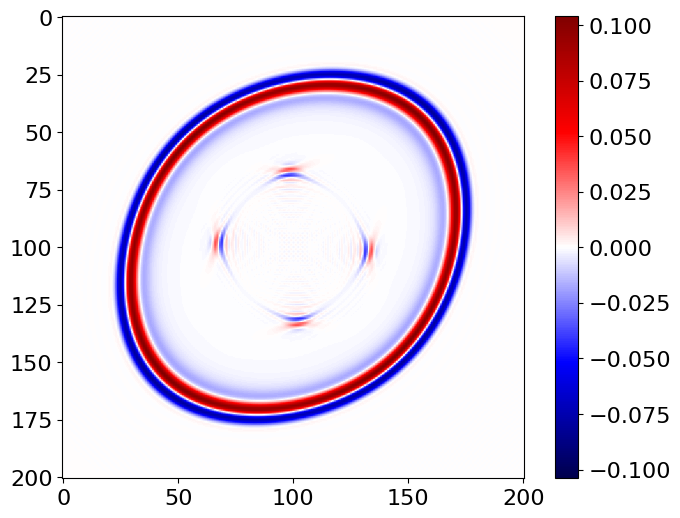

In [40]:
vmax = np.amax(np.abs(p_s.data[0]))
plt.imshow(p_s.data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

### Defining a variable velocity model

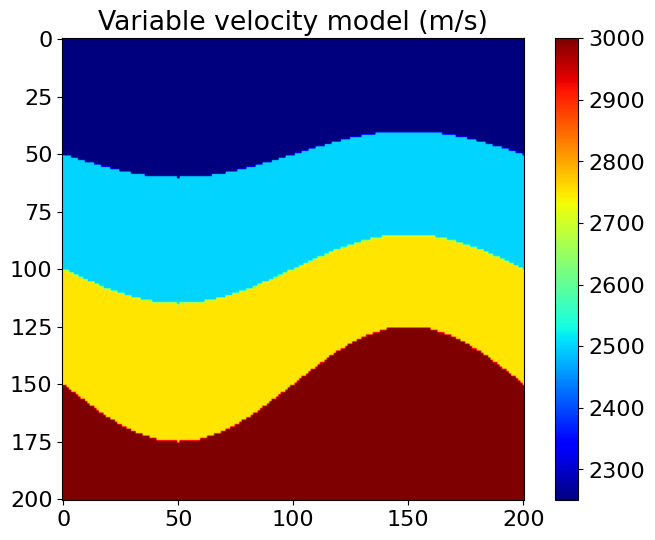

In [41]:
# Define a Devito Function for the velocity model
vp = dv.Function(name='vp', grid=grid)
# Create x, z coordinates for the meshgrid
x, z = grid.dimensions
x_vals, z_vals = np.meshgrid(np.linspace(0, 200, 201), np.linspace(0, 200, 201), indexing='ij')

# Define the velocity model with sinusoidal boundaries
vp.data[:] = 2250  # Top layer
vp.data[z_vals > 50 + 10*np.sin(2*np.pi*x_vals/200)] = 2500  # Second layer with sinusoidal boundary
vp.data[z_vals > 100 + 15*np.sin(2*np.pi*x_vals/200)] = 2750  # Third layer with sinusoidal boundary
vp.data[z_vals > 150 + 25*np.sin(2*np.pi*x_vals/200)] = 3000  # Fourth layer with sinusoidal boundary

# Apply Gaussian smoothing to smooth out the boundaries
smooth = 2  # You can adjust the sigma value to control the smoothness
#vp.data[:] = gaussian_filter(vp.data, sigma=smooth)

plt.imshow(vp.data.T, cmap='jet', interpolation='hanning')
plt.title('Variable velocity model (m/s)')
plt.colorbar()
plt.show()

### Propagating through the variable velocity model

In [42]:
# setting up a grid 
extent = (2000, 2000)
shape = (201, 201)
x = dv.SpaceDimension('x')
z = dv.SpaceDimension('z')
grid = dv.Grid(extent=extent, shape=shape, dimensions=(x, z))

# creating functions for the two pressure fields
p = dv.TimeFunction(name='p', grid=grid, space_order=8, time_order=2)
q = dv.TimeFunction(name='q', grid=grid, space_order=8, time_order=2)

# constants, sigma, epsilon and alpha are dimensionless, theta is radians, f0 is Hz
constants = {
    "delta": 0.1,
    "epsilon": 0.24,
    "sigma": 0.75,
    "theta": sp.pi/4,  # Keep symbolic pi here for symbolic operations
    "alpha": 1,
    "f0": 30
}

# Now use the Function objects directly in the velocity dictionary
v = {
    "pz": vp,
    "px": vp * dv.sqrt(1 + 2*constants["epsilon"]),
    "pn": vp * dv.sqrt(1 + 2*constants["delta"]),
    "sz": dv.sqrt((vp**2/constants["sigma"])*(constants["epsilon"]-constants["delta"]))
}

# Calculate the maximum value for each velocity field using their .data
# vmax = max(np.max(v["pz"].data), np.max(v["px"].data), np.max(v["pn"].data), np.max(v["sz"].data))
vmax = max(np.amax(vp.data*np.sqrt(1+2*constants["epsilon"])), np.amax(vp.data*np.sqrt(1+2*constants["delta"])))

# Define dt using the CFL condition, c=0.6
dt = float(np.amin(grid.spacing) * 0.6 / vmax)

# define a time range for the source term
t0 = 0
tn = 0.25
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# creating source term, f=0.03 kHz (30Hz)
src = RickerSource(name='src', grid=grid, f0=constants["f0"], npoint=1, time_range=time_range)
# setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# defining equations
theta = constants["theta"]
alpha = constants["alpha"]

# define equations
eq_p = p.dt2 - v["px"]**2 * h2(p, theta) - alpha * v["pz"]**2 * h1(q, theta) - v["sz"]**2 * (h1(p, theta) - alpha * h1(q, theta))
eq_q = q.dt2 - (v["pn"]**2 / alpha) * h2(p, theta) - v["pz"]**2 * h1(q, theta) + v["sz"]**2 * ((1 / alpha) * h2(p, theta) - h2(q, theta))

# # defining stencils
stencil_p = dv.Eq(p.forward, dv.solve(eq_p, p.forward))
stencil_q = dv.Eq(q.forward, dv.solve(eq_q, q.forward))

# injecting the source term to the pressure field, edit expr to vary source term
src_p = src.inject(field=p.forward, expr=src)
src_q = src.inject(field=q.forward, expr=src)

# # set up operator
op = dv.Operator([stencil_p, stencil_q] + src_p + src_q)
op(dt=dt)


Operator `Kernel` ran in 0.14 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.137361, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=5.999999999999999e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

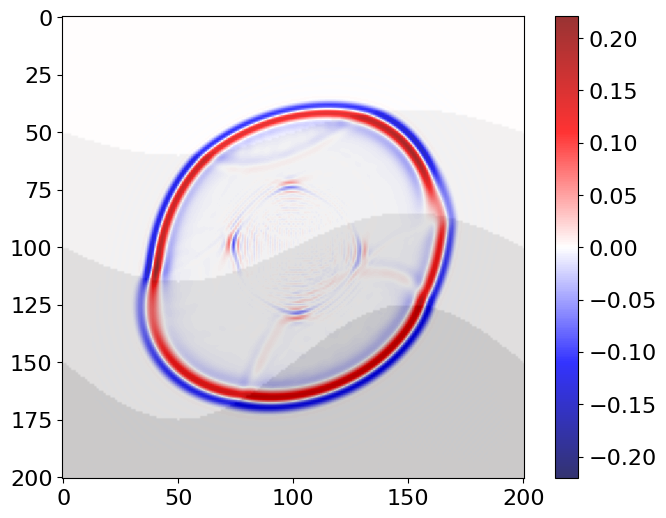

In [44]:
vmax = np.amax(np.abs(p.data[0]))
plt.figure(figsize=(8, 6))
plt.imshow(vp.data.T, cmap='Greys', interpolation='hanning')
plt.imshow(p.data[0].T, cmap='seismic', vmin=-vmax, vmax=vmax, alpha=0.8)
plt.colorbar()
plt.show()

### Scaling with maximum velocity